# Análise Equador

Neste notebook será feita a aplicação de série Temporal de Covid no Equador.

In [1]:
!pip install pymannkendall
# Importando as blibiotecas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
serie_equ = pd.read_csv('Séries Temporais Equador.csv')
serie_equ.drop('Unnamed: 0',axis=1,inplace=True)
# Transformado a coluna date de object para datetime
serie_equ['Date'] = pd.to_datetime(serie_equ['Date'],format='%Y-%m-%d')
serie_equ['Mês'] = serie_equ['Date'].dt.month
serie_equ.head()

,Date,Confirmed,Recovered,Deaths,Ano,Mês
0,2020-01-22,0,0.0,0,2020,1
1,2020-01-23,0,0.0,0,2020,1
2,2020-01-24,0,0.0,0,2020,1
3,2020-01-25,0,0.0,0,2020,1
4,2020-01-26,0,0.0,0,2020,1


In [3]:
# Colocando a coluna da data para indice
serie_equ.set_index('Date',inplace=True)
serie_equ.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713 entries, 2020-01-22 to 2022-01-03
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  713 non-null    int64  
 1   Recovered  713 non-null    float64
 2   Deaths     713 non-null    int64  
 3   Ano        713 non-null    int64  
 4   Mês        713 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 33.4 KB


In [4]:
# Aplicando para casos confirmados
resultado_conf = mk.original_test(serie_equ['Confirmed'])

nomes = ['Tendência','Presença de tendência','p-valor','Estatística do teste',
         'Tau Kendall','Pontuação Kendall','Variância S','Declive','Intercepto']


for i,j in zip(nomes,resultado_conf):
  print(i,":",j)

Tendência : increasing
Presença de tendência : True
p-valor : 0.0
Estatística do teste : 39.777706099860765
Tau Kendall : 0.9954772523125897
Pontuação Kendall : 252680.0
Variância S : 40351420.666666664
Declive : 904.990598970416
Intercepto : -99609.65323346813


In [5]:
# Aplicando para óbitos 
resultado_mortes = mk.original_test(serie_equ['Deaths'])

for i,j in zip(nomes,resultado_mortes):
  print(i,":",j)

Tendência : increasing
Presença de tendência : True
p-valor : 0.0
Estatística do teste : 39.71207164042783
Tau Kendall : 0.9937201569566794
Pontuação Kendall : 252234.0
Variância S : 40342120.666666664
Declive : 49.8
Intercepto : -3532.7999999999993


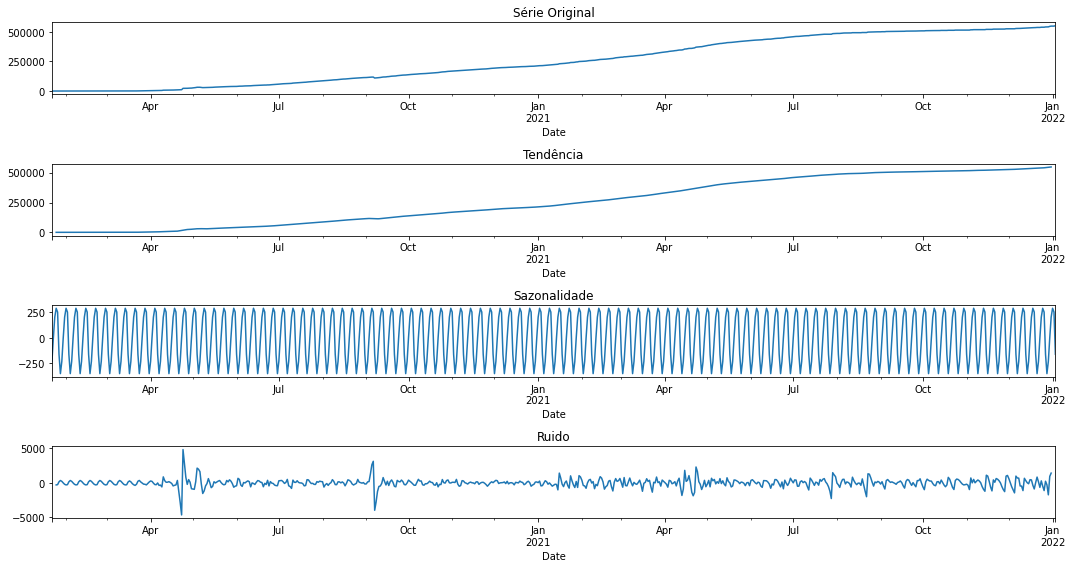

In [6]:
decom_conf = seasonal_decompose(serie_equ['Confirmed'])

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
decom_conf.observed.plot(ax=ax1,title='Série Original')
decom_conf.trend.plot(ax=ax2,title='Tendência')
decom_conf.seasonal.plot(ax=ax3,title='Sazonalidade')
decom_conf.resid.plot(ax=ax4,title='Ruido')
plt.tight_layout()

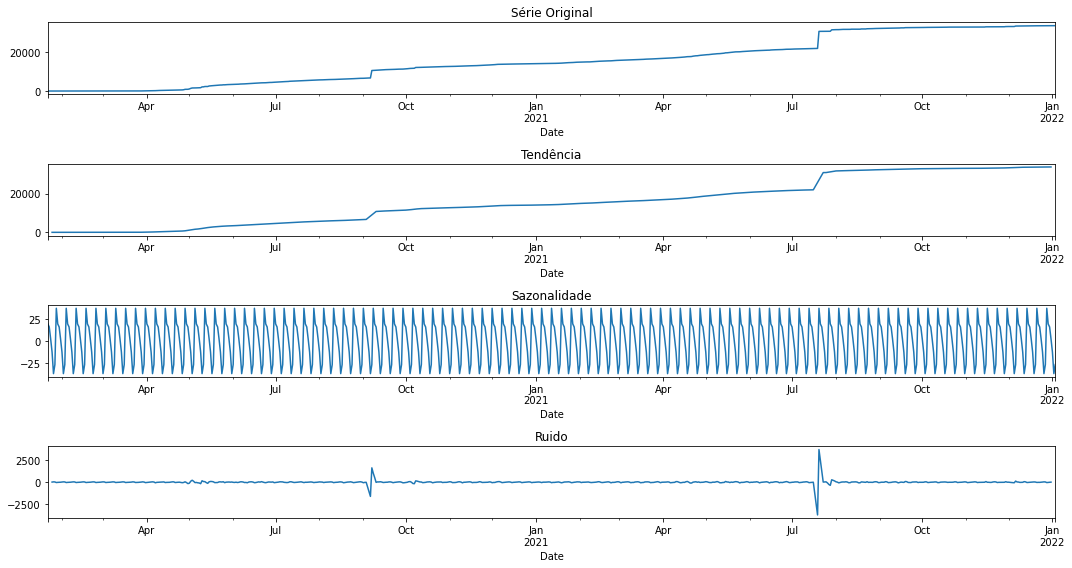

In [7]:
decom_morte = seasonal_decompose(serie_equ['Deaths'])

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
decom_morte.observed.plot(ax=ax1,title='Série Original')
decom_morte.trend.plot(ax=ax2,title='Tendência')
decom_morte.seasonal.plot(ax=ax3,title='Sazonalidade')
decom_morte.resid.plot(ax=ax4,title='Ruido')
plt.tight_layout()

In [8]:
# Separação entre treino e teste
treino = serie_equ[(serie_equ['Ano']<=2021)&(serie_equ['Mês']<12)]
teste = serie_equ[(serie_equ['Ano']==2021)&(serie_equ['Mês'] == 12)]

In [9]:
adf_conf = adfuller(serie_equ['Confirmed'])

print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(adf_conf[0]))
print('Valor-p: {:.4f}'.format(adf_conf[1]))
print('Valores Críticos:')
for key, value in adf_conf[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: 0.0134
Valor-p: 0.9596
Valores Críticos:
	1%: -3.4398
	5%: -2.8657
	10%: -2.5690


In [10]:
adf_mort = adfuller(serie_equ['Deaths'])

print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(adf_mort[0]))
print('Valor-p: {:.4f}'.format(adf_mort[1]))
print('Valores Críticos:')
for key, value in adf_mort[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -0.0381
Valor-p: 0.9553
Valores Críticos:
	1%: -3.4396
	5%: -2.8656
	10%: -2.5689


In [12]:
df_diff_co = serie_equ['Confirmed'].diff(1)
df_diff_mor = serie_equ['Deaths'].diff(1)

In [13]:
lag_acf_co = acf(df_diff_co.dropna(), nlags=25)
lag_pacf_co = pacf(df_diff_mor.dropna(), nlags=25)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


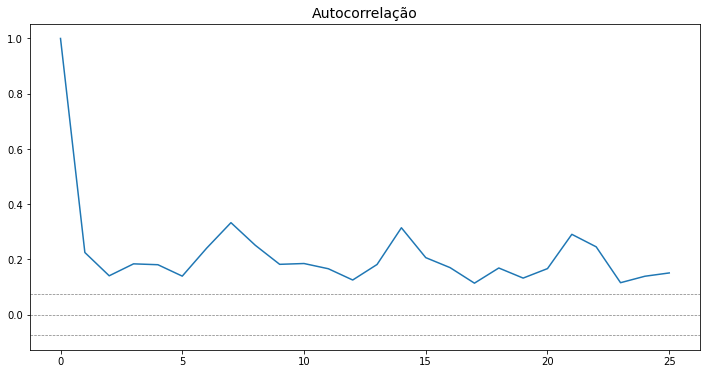

In [14]:
plt.figure(figsize=(12,6))
plt.plot(lag_acf_co)
plt.axhline(y=-1.96 / (np.sqrt((len(df_diff_co) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / (np.sqrt((len(df_diff_co) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação",fontsize=14)
plt.show()

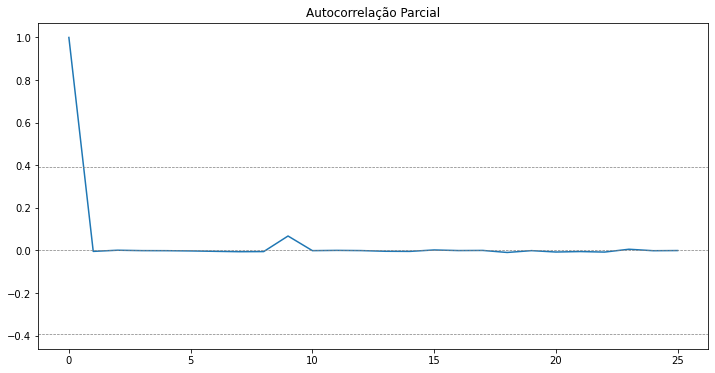

In [15]:
plt.figure(figsize=(12,6))
plt.plot(lag_pacf_co)
plt.axhline(y=-1.96 / (np.sqrt((len(lag_pacf_co ) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / (np.sqrt((len(lag_pacf_co ) - 1))), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação Parcial")
plt.show()

In [21]:
model = ARIMA(treino['Deaths'], order=(3,1,1))
result_AR = model.fit(disp = -1)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [22]:
fc, se, conf = result_AR .forecast(31, alpha=0.05)

In [23]:
mape = np.mean(np.abs(fc - teste['Deaths'].values)/np.abs(teste['Deaths'].values))
mae = np.mean(np.abs(fc - teste['Deaths'].values)) 
rmse = np.mean((fc - teste['Deaths'])**2)**.5
print(mape)
print(mae)
print(rmse)

0.016104854980660683
541.1456781719376
642.9007184312267


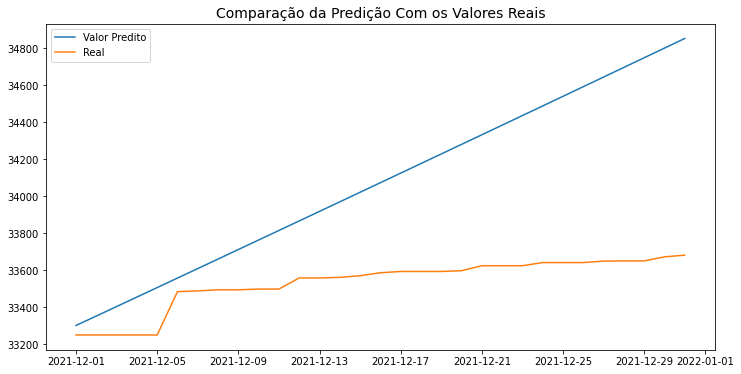

In [24]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()